<a href="https://colab.research.google.com/github/ChinmaySN/AI/blob/main/cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import files
files.upload()  # Upload your kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chinmaysn","key":"9c31f9c0c19677ee2c14ecc6aeb77079"}'}

In [14]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Replace with the correct Kaggle dataset slug
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip -d dataset/


Streaming output truncated to the last 5000 lines.
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: dataset/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: d

In [52]:
import os
import numpy as np
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [53]:
DATA_DIR = 'dataset/IDC_regular_ps50_idx5'
IMAGE_SIZE = 50
SAMPLE_SIZE = 25000  # per class max

data = []
labels = []
class_counts = {0: 0, 1: 0}
MAX_TOTAL = 50000

print("Loading data (target: 25k per class)...")

# Loop over patients
for patient_id in tqdm(os.listdir(DATA_DIR)):
    patient_path = os.path.join(DATA_DIR, patient_id)
    if not os.path.isdir(patient_path):
        continue

    for label in ['0', '1']:
        class_label = int(label)
        if class_counts[class_label] >= SAMPLE_SIZE:
            continue  # Skip if we already have enough for this class

        class_path = os.path.join(patient_path, label)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)

        for image_name in images:
            if class_counts[class_label] >= SAMPLE_SIZE:
                break
            image_path = os.path.join(class_path, image_name)
            try:
                image = cv2.imread(image_path)
                image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
                data.append(image)
                labels.append(class_label)
                class_counts[class_label] += 1
            except:
                continue

    if sum(class_counts.values()) >= MAX_TOTAL:
        break

print(f"Loaded {len(data)} images. Class distribution: {class_counts}")
data = np.array(data, dtype='float32') / 255.0
labels = np.array(labels)


Loading data (target: 25k per class)...


 32%|███▏      | 90/279 [00:09<00:20,  9.30it/s]


Loaded 50000 images. Class distribution: {0: 25000, 1: 25000}


In [54]:
# Split into train (70%), validation (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.30, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 35000
Validation samples: 7500
Test samples: 7500


In [55]:
def build_cancernet(input_shape):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

    model = Sequential()

    # Convolutional Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Block 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Block 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    return model


In [56]:

model = build_cancernet((IMAGE_SIZE, IMAGE_SIZE, 3))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 618,945 (2.36 MB)

 Trainable params: 618,497 (2.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [57]:

history_5 = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val)
)


Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.7505 - loss: 0.6120 - val_accuracy: 0.8049 - val_loss: 0.4505
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8253 - loss: 0.4085 - val_accuracy: 0.7956 - val_loss: 0.4477
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8414 - loss: 0.3711 - val_accuracy: 0.8056 - val_loss: 0.4529
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8462 - loss: 0.3539 - val_accuracy: 0.8140 - val_loss: 0.4130
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8568 - loss: 0.3358 - val_accuracy: 0.8137 - val_loss: 0.4585


In [58]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8135 - loss: 0.4448

Test Accuracy: 81.43%
Test Loss: 0.4546


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.76      0.92      0.83      3750
Malignant (1)       0.90      0.71      0.79      3750

     accuracy                           0.81      7500
    macro avg       0.83      0.81      0.81      7500
 weighted avg       0.83      0.81      0.81      7500



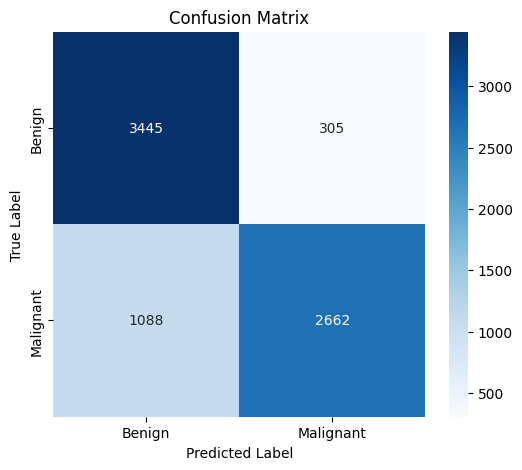

In [59]:
# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign (0)", "Malignant (1)"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [60]:
history_5 = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val)
)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8627 - loss: 0.3238 - val_accuracy: 0.8356 - val_loss: 0.3966
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8730 - loss: 0.2969 - val_accuracy: 0.8463 - val_loss: 0.3568
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8836 - loss: 0.2799 - val_accuracy: 0.8443 - val_loss: 0.3731
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8908 - loss: 0.2616 - val_accuracy: 0.8468 - val_loss: 0.3654
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9020 - loss: 0.2362 - val_accuracy: 0.8349 - val_loss: 0.3768
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9156 - loss: 0.2126 - val_accuracy: 0.8257 - val_loss: 0.4438
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9247 - loss: 0.1918 - val_accuracy: 0.8331 - val_loss: 0.4230
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9342 - loss: 0.1683 - val_accuracy

In [61]:

y_pred_prob = model.predict(X_test)

# (0 = Benign, 1 = Malignant)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


print("Predicted Labels: ", y_pred[:10])
print("True Labels:      ", y_test[:10])


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Predicted Labels:  [0 1 0 0 1 1 0 1 0 0]
True Labels:       [0 1 0 0 1 1 0 0 1 0]


In [46]:
model.save("CancerNet.keras")


In [47]:
from tensorflow.keras.models import load_model
model = load_model("CancerNet.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [62]:
def predict_image(filename, model, image_size=50):
    import cv2
    import numpy as np

    try:
        # Load and preprocess image
        img = cv2.imread(filename)
        img = cv2.resize(img, (image_size, image_size))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        # Predict
        pred = model.predict(img)[0][0]
        print(f"\nPrediction Score: {pred:.4f}")

        if pred > 0.5:
            print("Predicted: Malignant (1)")
        else:
            print("Predicted: Benign (0)")

    except Exception as e:
        print("Error while processing image:", e)


In [63]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Make prediction
predict_image(filename, model)


Saving 8863_idx5_x51_y1251_class0.png to 8863_idx5_x51_y1251_class0 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step

Prediction Score: 0.0240
Predicted: Benign (0)


In [64]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Make prediction
predict_image(filename, model)

Saving 8863_idx5_x151_y1451_class0.png to 8863_idx5_x151_y1451_class0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Prediction Score: 0.0564
Predicted: Benign (0)


In [65]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Make prediction
predict_image(filename, model)

Saving 8863_idx5_x201_y1201_class0.png to 8863_idx5_x201_y1201_class0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Prediction Score: 0.0063
Predicted: Benign (0)


In [66]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Make prediction
predict_image(filename, model)

Saving 8863_idx5_x101_y1301_class0.png to 8863_idx5_x101_y1301_class0 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Prediction Score: 0.7478
Predicted: Malignant (1)


In [67]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Make prediction
predict_image(filename, model)

Saving 8863_idx5_x201_y401_class0.png to 8863_idx5_x201_y401_class0.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Prediction Score: 0.0300
Predicted: Benign (0)


In [68]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Make prediction
predict_image(filename, model)

Saving 8863_idx5_x1001_y801_class1.png to 8863_idx5_x1001_y801_class1 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Prediction Score: 0.2107
Predicted: Benign (0)


In [69]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Make prediction
predict_image(filename, model)

Saving 8863_idx5_x1001_y851_class1.png to 8863_idx5_x1001_y851_class1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Prediction Score: 0.8894
Predicted: Malignant (1)


In [70]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Make prediction
predict_image(filename, model)

Saving 8863_idx5_x1001_y901_class1.png to 8863_idx5_x1001_y901_class1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Prediction Score: 0.8531
Predicted: Malignant (1)


In [71]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Make prediction
predict_image(filename, model)

Saving 8863_idx5_x1001_y951_class1.png to 8863_idx5_x1001_y951_class1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Prediction Score: 0.9710
Predicted: Malignant (1)


In [72]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Make prediction
predict_image(filename, model)

Saving 8863_idx5_x1001_y1551_class1.png to 8863_idx5_x1001_y1551_class1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Prediction Score: 0.9482
Predicted: Malignant (1)
